## JPEG圧縮(step.2)DCT+量子化

MSE : 21124.7109375
PSNR: 4.882895859258292
BITRATE : 8.0


True

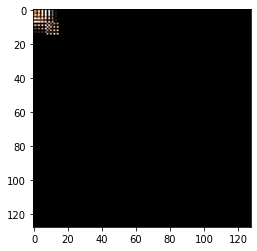

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# DCT hypor-parameter
T = 8
K = 8  # 係数はすべて用いるものとする
channel = 3

#DCT weight
def DCT_w(x, y, u ,v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
        
    theta = np.pi/(2*T)
    
    return ((2*cu*cv/T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
def dct(img):
    H, W, _ = img.shape
    F = np.zeros((H, W, channel), dtype=np.float32)
    
    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        for y in range(T):
                            for x in range(T):
                                F[v+yi, u+xi, c] += img[y+yi, x+xi, c]*DCT_w(x, y, u, v)
                                
    return F

# IDCT
def idct(F):
    H, W, _  =F.shape
    out = np.zeros((H, W, channel), dtype=np.float32)
    
    for c in range(channel):
        for yi in range(T):
            for xi in range(T):
                for y in range(T):
                    for x in range(T):
                        for u in range(K):
                            for v in range(K):
                                out[y+yi, x+xi, c] +=F[v+yi, u+xi , c]*DCT_w(x, y, u, v)
    
    out = np.clip(out, 0, 255)
    out = np.round(out).astype(np.uint8)
    
    return out

# Quantization
def quantization(F):
    H, W, _ = F.shape
    
    # これは量子テーブル？何故この値を使うのか？
    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61), 
                 (12, 12, 14, 19, 26, 58, 60, 55),
                 (14, 13, 16, 24, 40, 57, 69, 56), 
                  (14, 17, 22, 29, 51, 87, 80, 62), 
                  (18, 22, 37, 56, 68, 109, 103, 77),
                 (24, 35, 55, 64, 81, 104, 113, 92),
                 (49, 64, 78, 87, 103, 121, 120, 101), 
                 (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    for ys in range(0, H, T):
        for xs in range(0, W, T):
            for c in range(channel):
                # Qでわって丸めたものにQをかけている
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

                
    return F

#MSE
def MSE(img1, img2):
    H, W, _  =img1.shape
    mse = np.sum((img1-img2)**2) / (H*W*channel)  # channel忘れがち
    return mse

#PSNR
def PSNR(mse, vmax=255):
    mse = 10*np.log10(vmax**2/mse)
    return mse

def BITRATE():
    return 1.*T*K*K/T/T

# image read
img = cv2.imread('../imori.jpg').astype(np.float32)

# DCT
F = dct(img)

# quantization
F = quantization(F)

# IDCT
out = idct(F)

# mse
mse = MSE(img, out)

# PSNR
psnr = PSNR(mse)

# bitrate
bitrate = BITRATE()

print(f'MSE : {mse}')
print(f'PSNR: {psnr}')
print(f'BITRATE : {bitrate}')

plt.imshow(out)
cv2.imwrite('out38.jpg', out)